# DSCI 575 - Advanced Machine Learning

# Lab 4: Long Short Term Memory networks  

## Table of contents
- [Submission guidelines](#sg)
- [Learning outcomes](#lo)
- [Exercise 1: Text generation with LSTMs](#1)
- [Exercise 2: Text classification with LSTMs](#2)

## Submission guidelines <a name="sg"></a>

#### Tidy submission
rubric={mechanics:2}
- To submit this assignment, submit this jupyter notebook with your answers embedded.
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Use proper English, spelling, and grammar throughout your submission.

#### Code quality and writing
- These rubrics will be assessed on a question-by-question basis and are included in individual question rubrics below where appropriate.
- See the [quality rubric](https://github.com/UBC-MDS/public/blob/master/rubric/rubric_quality.md) and [writing rubric](https://github.com/UBC-MDS/public/blob/master/rubric/rubric_writing.md) as a guide to what we are looking for.
- Refer to [Python PEP 8 Style Guide](https://www.python.org/dev/peps/pep-0008/) for coding style.

In [3]:
import numpy as np
import pandas as pd
import numpy.random as npr
import os, sys, re
import collections
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from urllib.request import urlopen
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kvarada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kvarada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kvarada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

## Learning outcomes <a name="lo"></a>

In this lab, we will carry out two tasks using Long Short Term Memory networks (LSTMs). 

1. Text generation
2. Text classification

After working on this lab, you will be able to 

- explain text generation using LSTMs 
- implement, debug, and explain text classification using LSTMs 

## Exercise 1: Text generation with LSTMs <a name="1"></a>

In lab 2 you generated text using a Markov model. A weakness of this approach is that the model cannot maintain long-term state. For example, imagine you wanted to model/generate a sentence like

> Hello, my name is Alex (but really it's Alexandra, I just go by Alex for short).

Well, that's tricky: how does the model to remember to close the parentheses? If you're using $n=10$ characters, then when it comes time to close the parentheses you've completely forgotten that you've opened them! And yet, on the other hand, it's completely infeasible to use $n=50$ or $n=100$ for the Markov model, as you'll just have one example of each training sequence. We're going to address this conundrum using LSTMs, which are a type of Recurrent Neural Network (RNN). The [long-short term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) model allows us to use large $n$ in a practical way.

LSTMs take long to train. So for this exercise, I am going to provide you with the weights of a trained network, and you will use the weights to generate random text.

**Some things you should know:**

- We're doing everything with characters here, not words. 
- With the LSTM, the data matrix `X` is now 3-dimensional instead of 2-dimensional. The dimensions are 
  1. number training examples
  2. sequence length (this is the $n$ of the $n$-grams) 
  3. number of features, which in this case is a 1-hot encoding of the $d$ characters in our vocabulary
- My model uses $n=100$, with 3 LSTM layers and 50% dropout. 
- My model only considers the $d=100$ most common characters, which captures the vast majority of all characters appearing in the corpus. There are over 4000 unique characters in the corpus but most appear very few times; including them would slow things down a lot, and would be unnecessary. (It's just a coincidence that $n=d$ here, there's no reason they need to be the same number. In hindsight I wish I used $n=50$ to speed everything up 2x.)

**Attributions:** the model architecture is inspired by [this blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (which uses Torch rather than Keras). The Keras code is loosely based on code from the book [Deep Learning with Python](https://machinelearningmastery.com/deep-learning-with-python2/), with permission from the author.

**To get going:**

0. Highly recommended: read [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
1. Download the [weights](https://github.ubc.ca/MDS-2018-19/datasets/blob/master/data/LSTM-weights-wiki1MB.hdf5) and the [raw Wikipedia data](https://github.ubc.ca/MDS-2018-19/datasets/blob/master/data/wiki1MB.txt) from the [datasets repo](https://github.ubc.ca/ubc-mds-2016/datasets) and place them in the `data` directory. (The reason we also need the raw data is twofold: (1) is so that we can seed the generator with a random sequence of real data, and (2) so that we can extract the "vocabulary" of the top $d$ words, and then re-generate the mapping from these words to integers for the one-hot encoding.)
2. Run the code :

```
python textgen.py gen "data/wiki1MB.txt" --weightsfile="data/LSTM-weights-wiki1MB.hdf5"
```

**Please do not push your `data` folder.**

You should be able to do this on your local machine using a CPU. It's pretty cool that a model trained on a GPU can then be run with no modifications on a CPU, thanks to TensorFlow. The code to train the network is all there too; you can look at it if you're interested, but you don't have to do anything with it. 

**Troubleshooting:**

If you have problems, you may need to get yourself the same version of Keras and TensorFlow used to train the model. You can achieve this with

```
pip install keras==2.0.2
pip install tensorflow==1.0.0
```

Beyond this, you may occasionally encounter the error described [here](http://stackoverflow.com/questions/40560795/tensorflow-attributeerror-nonetype-object-has-no-attribute-tf-deletestatus) and [here](https://github.com/tensorflow/tensorflow/issues/3388). If it happens to you: don't panic, and just try re-running the code. It seems like this bug [was fixed in tensorflow 1.1.0](https://github.com/tensorflow/tensorflow/commit/90d964f3382faf30d291aa3fbdb509844e1f042a).

If you're getting an "out of memory" error, open textgen.py and change the line

```
n_examples = len(text) - seq_length
```

to

```
n_examples = 10000
```

This will use 100x less memory. It would mess up training but for generating sequences it is fine; the only consequence is that the seed text will be chosen from within the first 1% of the data file (no big deal). There are more proper fixes but this is quick and easy for now.

### 1(a) Generate text using LSTMs 
rubric={reasoning:4} 

1. Play around with the code. 
2. Paste some sample output along with the seed here in this notebook so the TAs know what you got. 
3. Comment on the behaviour of the LSTM model as compared to the Markov model from lab 2.

### YOUR ANSWER HERE

### 1(b) Temperature
rubric={reasoning:4}

At this point you've hopefully had success generating some text. Unfortunately, you won't be able to try different input files as the network is already trained (unless you want to try training a new one!). However, you can play with the `temperature` parameter, described in the context of this project [here](https://github.com/karpathy/char-rnn#sampling) and more generally softmax with temperature [here](https://en.wikipedia.org/wiki/Softmax_function). Let's define temperature, $T$, in a simpler (and hopefully mathematically equivalent) way than usual: 

- we take all our class probabilities (of different next characters) outputted by the model, and raise them to the power of $1/T$
- then we re-normalize the probabilities so that they sum to 1

In [4]:
def temper(p,T):
    p = p**(1/T)
    return p/np.sum(p)

(Note that this does nothing when $T=1$.)

To build an intuition for this, let's look at an example that has nothing to do with machine learning. Consider the (discrete) probability distribution below:

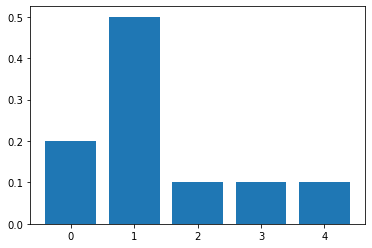

In [5]:
probs = np.array([0.2, 0.5, 0.1, 0.1, 0.1])
plt.bar(range(5), probs);

Now we can see what happens at $T=0.5$.

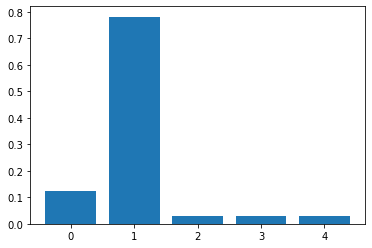

In [6]:
plt.bar(range(5), temper(probs, T=0.5));

And $T=0.25$:

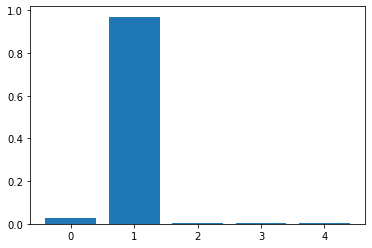

In [7]:
plt.bar(range(5), temper(probs, T=0.25));

As you can see, a lower temperature _makes the probability distribution more extreme_. If you went all the way to $T=0$ then you'd have probability 1 of the most likely outcome and 0 for all others; in other words, at each iteration you'd just predict the argmax of the probability distribution rather than sampling from it (this would then be a deterministic model, not a random one). And if $T=1$ then we're just sampling from the original distribution, which is what you did with the Markov model. 

The take-home message is: lower temperatures cause the model to output text that is more just memorized from the training data, whereas higher temperatures allow "crazier" or "more creative" outputs than might be more fun but also might make less sense.

Some optional notes: 

- Yes, this is related to temperature in physics. Boltzmann distribution, etc.
- This is why softmax is called softmax. When we set $T=0$ we get the "hard" max of the numbers because we just pick out the biggest one. Setting $T>0$ makes it the "soft" max.
- You could have taken this same notion of temperature and apply it to your Markov model from before, but that's not part of the assignment.


**Your task**

1. Play around with different temperature values. You can do that by passing the temperature argument to the script (`-t TEMPERATURE`). You can look up all the possible arguments of the script with: 

    `python textgen.py --help`

2. Paste your output for different temperatures here in the notebook.  
3. Discuss how temperature affects the output, qualitatively by inspection.

### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### YOUR ANSWER HERE

## Exercise 2: Text classification with LSTMs <a name="2"></a>

In this exercise, we will train long short term memory models (LSTMs) for text classification. In particular, we'll be classifying "toxic" comments. 

Some background on the problem: One of the key challenges facing online communities, from social media to the comment sections of news sites, is content moderation. Content moderation is often a task of filtering out, i.e., deleting toxic and abusive content. (I think in DSCI 541 you talked a bit about the documentary [The Cleaners](https://www.youtube.com/watch?v=JA1DxRdT2hA).) Written abusive content can be found on online commenting platforms and there is a growing interest in developing automation to help filter and organize online comments for both moderators and readers. 

In this exercise we'll develop a deep learning model to identify "toxic" comments. We will be using [Toxic Comment Classification Challenge data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) from Kaggle. You can download it [here](https://www.kaggle.com/c/8076/download-all). **Sorry for the offensive language in the toxic comments; it's the reality of such platforms 😔. If you are sensitive to such language try not to look at the examples where `toxic` label is 1.** 


LSTMs are expensive to train and for this exercise, I recommend that you work on the cloud using [Google colab](https://colab.research.google.com/notebooks/welcome.ipynb). This will allow you to train on a GPU and assess the benefits of training neural networks on GPUs.

You will follow the steps below.

- Save this Jupyter notebook so that it contains your latest work. Also push it to GitHub to be safe.
- Go to [Google colab](https://colab.research.google.com/). 
- Make an account if you don't have one.
- Select "UPLOAD" and upload this notebook itself, lab4.ipynb, which you just saved.
- Runtime --> change runtime type --> Select GPU.
- SUGGESTION: once you're done all your work on Colab, you can download the notebook from Colab and overwrite your local version. That way any work you did on Colab won't be lost. (They allow working directly off a notebook on GitHub, but that feature won't work for us since we're using github.ubc.ca.)

### 2(a) Data and preprocessing 
rubric={reasoning:2, mechanics:2}

Download the data from [here](https://www.kaggle.com/c/8076/download-all). Unzip the file. We'll be using only `train.csv`. You will need to upload it to your Google drive. I am providing starter code to read the data CSV below. Replace the path with your downloaded path. The dataset has 159,571 labeled comments. Also, In general, on online commenting platforms, the number of toxic comments is much smaller than non-toxic comments as can be seen in the value counts below. It's not recommended in general, but for this assignment I am extracting a small subset of comments with equal number of toxic and non-toxic comments. The final corpus is stored in `small_toxicity_df`. Note: Feel free to experiment with a larger sample. 

Your tasks: 
1. Preprocess `comment_text`. You can carry out preprocessing you think is appropriate for this problem, using the preprocessing library of your choice. 
2. Create train test splits for `small_toxicity_df`. 

In [ ]:
# You will need to upload your downloaded datafile to Google drive and mount the drive as follows. 
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
### BEGIN STARTER CODE
# Data loading and preprocessing
df = pd.read_csv('/content/gdrive/My Drive/<YOUR-DATA-PATH>', encoding = "ISO-8859-1")
print('Number of comments', df.shape)
print(df['toxic'].value_counts())

# Create a smaller and balanced corpus of toxic and non-toxic comments
# Probably not a great idea to create a balanced sample here. 
# But we'll do it for this lab.
# You are welcome to think about it and share your thoughts. 
toxic_df = df[df['toxic'] == 1]
non_toxic_df = df[df['toxic'] == 0]
small_toxic_df = toxic_df.sample(n = 10000)
small_non_toxic_df = non_toxic_df.sample(n = 10000)
small_toxicity_df = pd.concat([small_non_toxic_df, small_toxic_df])
### END STARTER CODE

In [ ]:
### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### 2(b) Baseline system
rubric={accuracy:2,reasoning:1}

We will train logistic regression with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) as our baseline. 

- Get the sparse bag-of-words representation of the comments using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
- Train [scikit-learn's LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier. 
- Report the accuracies on the train and test portions.

In [ ]:
### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### YOUR ANSWER HERE


### 2(c) Text classification with LSTMs
rubric={reasoning:5}

The starter code below for the class `DLTextClassifier` has methods for data preparation, building network, training, evaluating, and predicting. 

Your tasks: 
1. Read the provided methods and write the missing docstrings. 
2. We saw that in text generation our `X` which was input to the network was a 3-D tensor and `y` was a 2-D matrix. Comment on the dimensions of `X` and `y` in this case. 

In [ ]:
### YOUR ANSWER HERE        

In [ ]:
### BEGIN STARTER CODE
class DLTextClassifier():
    def __init__(self, 
                 embedding_dimension = 200,
                 max_features = 20000, 
                 maxlen = 80):
        """
        Instantiate the DLTextClassifer.              
        Parameters:
        ------------------        
        embedding_dimension : (int)
            size of your word embedding vector
        max_features: (int)
            max number of words to keep in the vocabulary
        maxlen : (int)
            sequence length
        """
        # We'll be using an embedding layer and pass a vector of
        # size embedding dimension instead of one-hot-encoding. 
        self.embedding_dimension = embedding_dimension

        # Only consider max_features features to prevent from 
        self.max_features = max_features
        
        # Sequence length
        self.maxlen = maxlen
        
        # Create the tokenizer. We'll be using Keras Tokenizer here.         
        self.tokenizer = Tokenizer(num_words=self.max_features, 
                             filters='! #$% ()*+,-./:; = ?@[\\]^_`{|}~\t\n>"<')
        
        # Store word_index
        self.word_index = self.tokenizer.word_index
                
    def prepare_data(self, corpus, mode = 'train'):
        """              
        YOUR DOCSTRING HERE.        
        """
        if mode == 'train': 
            # fit the tokenizer on the documents
            self.tokenizer.fit_on_texts(corpus)
        
        # integer encode documents
        encoded_corpus = self.tokenizer.texts_to_sequences(corpus)        
        print('len of encoded docs: ', len(encoded_corpus))
        return self.pad_sequences(encoded_corpus)

    def pad_sequences(self, data):
        """
        YOUR DOCSTRING HERE.
        """
        print('Pad sequences (samples x time)')
        padded_data = sequence.pad_sequences(data, maxlen=self.maxlen)
        print('Padded data shape:', padded_data.shape)
        return padded_data    
          
    def build_network(self, layer_size = 256, dropout_amount=0.5):
        """
        Given layer_size and dropout_amount, build an LSTM network
        using Keras and tensorflow and print summary of the model. 

        Parameters
        -----------
        layer_size : int
          The number of units to be passed in the LSTM layer
        dropout_amount : float
          the dropout amount to be passed in the Dropout layer. 

        Return
        -----------
        None
          print the summary of the model 
        """      
        # YOUR CODE HERE 

                
    def fit(self, 
              X_train, y_train,
              batch_size =32, 
              epochs = 10, 
              save_path='/content/gdrive/My Drive/<YOUR MODEL PATH>'):
        """        
        Given the parameters train a deep learning model and save and return it.  
        
        Parameters
        -------------
        X_train : (list) 
          the X values of the train split 
        y_train : (list) 
          the y values of the train split 
        batch_size : (int) 
          the batch_size for the training
        epochs : (int) 
          the number of epochs for training 
        save_path : (str) the path to save the model
        
        Return
        -------------
          the trained model
        """      
        # YOUR CODE HERE 


    def evaluate(self, X_test, y_test):
        """
        Given a model and X_test, y_test, evaluates the model and prints 
        the accuracy
        
        Parameters
        -----------
        X_test -- Array of text data
        y_test -- labels for every text
        
        Return:    
        -----------    
        None                
        """        
        X_test_padded = self.prepare_data(X_test, mode='test')        
        score, acc = self.model.evaluate(X_test_padded, y_test)
        print('Accuracy: ', acc)


    def predict(self, texts):
        """
        Return predicted labels for a list of texts.        

        Parameters
        -----------
        
        texts : (list) 
          a list of text comments

        Return:
        --------        
          a list of prediction scores        
        """        
        padded_sequences = self.prepare_data(texts, mode = 'test')
        return self.model.predict(padded_sequences)
### END STARTER CODE    

### 2(d) Build LSTM network
rubric={accuracy:4,reasoning:4}

In this exercise you will build an LSTM network . Complete the method `build_LSTM` in the class above. In particular, your tasks are: 

1. Add Keras layers to build an LSTM. You may create as many layers of LSTMs as you want. 
2. Compile and store the model in `self.model` and print the summary of the model. 
3. Create a class object and check whether your code is working so far. 
4. Briefly explain your network in words. Comment on the input and output dimensions of each layer in the network. How many total parameters are there? What is the effect of having an embedding layer on the number of parameters? 

**Hint**: You may refer to [Keras examples for text classification using LSTM](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) when you build layers.


In [ ]:
### YOUR ANSWER HERE

### 2(e) Training LSTMs
rubric={accuracy:3,reasoning:2}

Train a deep learning model. In particular, 

1. Complete the class method `fit`. You'll have to prepare the data first using `prepare_data` class method (which is already provided) and then `fit` the model. 
3. Call the `fit` method and experiment with different hyperparameters of your choice. Note your observations. 

In [ ]:
### YOUR ANSWER HERE

### 2(f) Evaluating LSTM performance

rubric={accuracy:2,reasoning:4}

1. Call the class method `evaluate` to evaluate the model on the test set. 
2. Compare your results with the results in 2(b). 
3. Create some fake comments and get and examine model predictions on these comment using the `predict` method of the class. 
4. Note your observations. Do you think it would be reasonable to use your system in real-life applications to moderate online content?  

In [ ]:
### YOUR ANSWER HERE

In [ ]:
### YOUR ANSWER HERE

### (optional) 2(g): Train GRUs and bidirectional LSTMs
rubric={reasoning:1}

- Train [GRUs](https://keras.io/layers/recurrent/#gru) and [bidirectional LSTMs](https://keras.io/layers/wrappers/#bidirectional)
- Compare your results with results in 2(e). 

### (optional) 2(h): Use pre-trained embeddings 
rubric={reasoning:1}

- Currently you are using an embedding layer, where you are training your word embeddings, a word representation of size `embedding_size`. Try using pre-trained embeddings instead. 
- Compare your results with the results in 2(e). 